In [5]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [6]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [7]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


Image size = 400,400


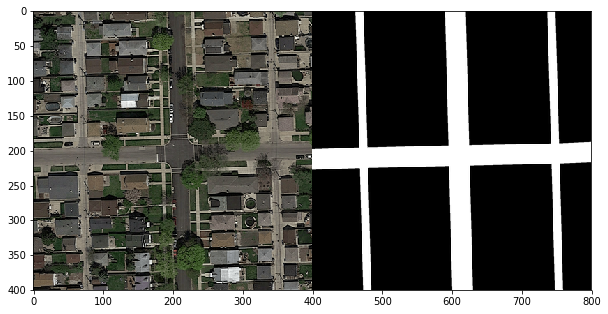

In [8]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [9]:
# Extract patches from input images
patch_size = 8 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [10]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray(img_patches)
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [11]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
X_standardized = preprocessing.scale(X)

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(2, 2), random_state=1)
clf.fit(X_standardized, Y) 

# Run prediction on the img_idx-th image
img_idx = 9

Xi = extract_img_features(image_dir + files[img_idx])
print(Xi)
Zi = clf.predict(Xi)
Zi

# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

In [ ]:
from sklearn import cross_validation
from sknn.mlp import Classifier, Layer, Convolution


X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, Y, test_size=0.2)


# Create a neural network that uses convolution to scan the input images.
nn = Classifier(
    layers=[
        Convolution('Rectifier', channels=12, kernel_shape=(3, 3), border_mode='full'),
        Convolution('Rectifier', channels=8, kernel_shape=(3, 3), border_mode='valid'),
        Layer('Rectifier', units=64),
        Layer('Softmax')],
    learning_rate=0.002,
    valid_size=0.2,
    n_stable=10,
    verbose=True)

nn.fit(X, Y)


# Determine how well it does on training data and unseen test data.
print('\nTRAIN SCORE', nn.score(X_train, y_train))
print('TEST SCORE', nn.score(X_test, y_test))

y_pred = nn.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Initializing neural network with 4 layers, 192 inputs and 2 outputs.
  - Convl: Rectifier  Output: (10, 10)   Channels: 12
  - Convl: Rectifier  Output: (8, 8)     Channels: 8
  - Dense: Rectifier  Units:  64  
  - Dense: Softmax    Units:  2   

Training on dataset of 250,000 samples with 48,500,000 total size.
  - Reshaping input array from (250000, 8, 8, 3) to (200000, 3, 8, 8).
  - Train: 200,000    Valid: 50,000
  - Early termination after 10 stable iterations.

Epoch       Training Error       Validation Error       Time
------------------------------------------------------------
    1         ..............................................                                                            4.677e-01             4.134e-01         56.8s
    2         ..............................................                                                            4.195e-01             4.102e-01         67.4s
    3         ..............................................              

In [9]:
print(y_pred.shape)

(12500, 1)


In [10]:
def load_training_img(idx):
    img_patches = [img_crop(imgs[idx], patch_size, patch_size)]
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    return np.asarray(img_patches)

In [11]:
def showTrainingPred(img_idx):
    Xi = load_training_img(img_idx)
    Zi = nn.predict(Xi)
    # Display prediction as an image

    w = gt_imgs[img_idx].shape[0]
    h = gt_imgs[img_idx].shape[1]
    predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
    cimg = concatenate_images(imgs[img_idx], predicted_im)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')

    new_img = make_img_overlay(imgs[img_idx], predicted_im)

    plt.imshow(new_img)

[(625, 2)]


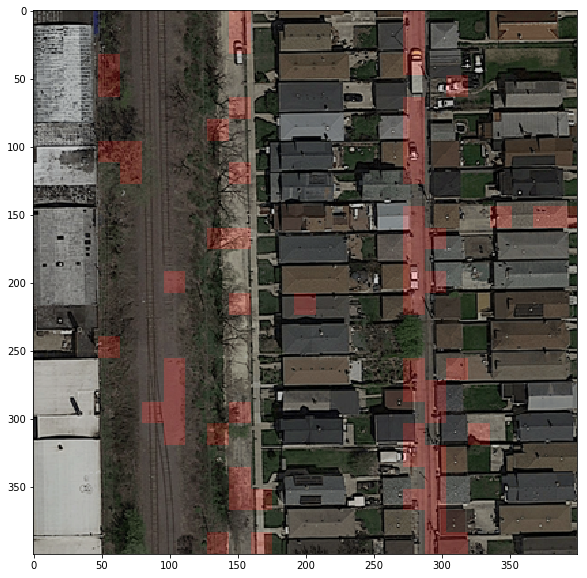

In [12]:
showTrainingPred(19)

In [13]:
def load_test_imgs():
    #1444 tiles per image
    n=50
    test_directory = "test_set_images/test_"
    imgs = [load_image(test_directory + str(i)+"/test_"+str(i)+".png") for i in range(1,n+1)]
    img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
    img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
    return imgs, np.asarray(img_patches)

imgs_test, a = load_test_imgs()

In [14]:
print(a.shape)

(72200, 16, 16, 3)


In [15]:
yolo = nn.predict(a)

[(72200, 2)]


In [16]:
print(yolo.shape)

(72200, 1)


In [17]:
def showTestImg(idx):

    w = 608
    h = 608
    predicted_im = label_to_img(w, h, patch_size, patch_size, yolo[1444*idx:1444*(idx+1)])
    cimg = concatenate_images(imgs_test[idx], predicted_im)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')

    new_img = make_img_overlay(imgs_test[idx], predicted_im)

    plt.imshow(new_img)

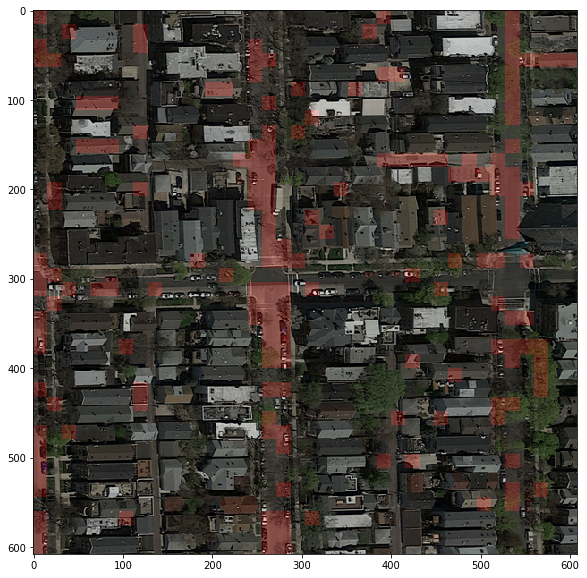

In [18]:
#la 5, 6 et 8 sont pas mal
idx_test = 20
showTestImg(idx_test)

In [19]:
import matplotlib

In [20]:
def saveTestImgsOutput():
    w = 608
    h = 608
    for i in range(50):
        predicted_im = label_to_img(w, h, patch_size, patch_size, yolo[1444*i:1444*(i+1)])
        nameToSave = 'test_set_results/img_'+str(i+1)+'.png'
        G = np.zeros((w,h,3))
        G[predicted_im>0.5] = [1,1,1]
        G[predicted_im<0.5] = [0,0,0]
        matplotlib.image.imsave(nameToSave, G)
saveTestImgsOutput()